**Library Imports**

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import os
import seaborn as sns

from scipy.stats import zscore

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

from matplotlib import pyplot
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from IPython.display import display

from imblearn.over_sampling import SMOTE

import tensorflow as tf

Panda Preferences

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

Read CSV

In [3]:
df = pd.read_csv("../Datasets/2022_combined.csv")
display(df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,type
0,CyjkPY35EAAJZFi01,192.168.1.15,39222,192.168.1.5,80,tcp,-,0.000111,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000111,1,1,0,0,9020.008602,9020.008602,18040.017204,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,110.864639,1.108646e+02,1.108646e+02,1.108646e+02,0.000000e+00,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.864639,1.108646e+02,1.108646e+02,1.108646e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64240,0,64240,0,http_flood
1,CBL1gm4jBAqsjSNhda,192.168.1.15,39302,192.168.1.5,80,tcp,-,3.1e-05,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000031,1,1,0,0,32263.876923,32263.876923,64527.753846,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,30.994415,3.099442e+01,3.099442e+01,3.099442e+01,0.000000e+00,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.994415,3.099442e+01,3.099442e+01,3.099442e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64240,0,64240,0,http_flood
2,Cmj0NZ62rJ2OIpfSh,192.168.1.15,39316,192.168.1.5,80,tcp,-,9.1e-05,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000091,1,1,0,0,10979.853403,10979.853403,21959.706806,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,91.075897,9.107590e+01,9.107590e+01,9.107590e+01,0.000000e+00,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.075897,9.107590e+01,9.107590e+01,9.107590e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64240,0,64240,0,http_flood
3,Ce9Qki4sd0QxGegSCb,192.168.1.15,39370,192.168.1.5,80,tcp,-,3.2e-05,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000032,1,1,0,0,31300.776119,31300.776119,62601.552239,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,31.948090,3.194809e+01,3.194809e+01,3.194809

Fix Dataframe Mixed Types

In [4]:
# Remove rows with '-' character in columns 7, 8 and 9
cols_to_check = ['duration', 'orig_bytes', 'resp_bytes']
#cols_to_check = ['duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'history', 'flow_duration']

mask = df[cols_to_check].apply(lambda x: x.str.contains('-', na=False)).any(axis=1)
df = df[~mask]

# Replace comma with period as decimal separator

cols_to_float = ['duration']
df[cols_to_float] = df[cols_to_float].replace(',', '.', regex=True)

# Convert columns 7, 8, 9, and 17 to float and int data type
cols_to_int = ['orig_bytes', 'resp_bytes']

df[cols_to_float] = df[cols_to_float].astype(float)
df[cols_to_int] = df[cols_to_int].astype(int)

-----------------------------------------------------------

**DF Statistics and Info**

In [5]:
def display_information_dataframe(df_cop):
    summary_data = [{'Data Type': dtype, 'Column Name': col, 'Unique Values': df_cop[col].unique()} for col, dtype in df_cop.dtypes.iteritems()]
    summary_df = pd.DataFrame(summary_data)
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    return summary_df

In [6]:
display_information_dataframe(df)

,Data Type,Column Name,Unique Values
0,object,uid,"[CyjkPY35EAAJZFi01, CBL1gm4jBAqsjSNhda, Cmj0NZ..."
1,object,id.orig_h,"[192.168.1.15, 192.168.1.12, 192.168.1.10, 192..."
2,int64,id.orig_p,"[39222, 39302, 39316, 39370, 39414, 39510, 395..."
3,object,id.resp_h,"[192.168.1.5, 35.224.170.84, 192.168.1.1, 34.1..."
4,int64,id.resp_p,"[80, 1880, 5683, 1883, 53, 123, 53197, 60635, ..."
5,object,proto,"[tcp, udp, icmp]"
6,object,service,"[-, http, dns, ntp, ssl, dhcp]"
7,float64,duration,"[0.00011100000000000001, 3.1e-05, 9.1e-05, 3.2..."
8,int64,orig_bytes,"[0, 353, 181, 182, 2655, 4150, 4100, 470, 705,..."
9,int64,resp_bytes,"[0, 294, 2460, 2680, 2144, 95, 108, 148, 48, 1..."


--------------------------------------------

**Pre-processing and Data Encoding**

Split History

In [7]:
def count_letters(string, is_upper):
    count = 0
    for c in string:
        if is_upper and c.isupper():
            count += 1
        elif not is_upper and c.islower():
            count += 1
    return count

In [8]:
df['history_originator'] = df['history'].apply(lambda x: count_letters(x, True))
df['history_responder'] = df['history'].apply(lambda x: count_letters(x, False))

One Hot Encoding

In [9]:
def one_hot_encoding(df, columns):
    for col in columns:
        print(f'[ONE HOT ENCONDING] {col}')
        df = pd.get_dummies(df, columns=[col], prefix=col)
    return df

In [10]:
cols_to_encode = [
    'proto',
    'conn_state',
    'fwd_header_size_min',
    'fwd_header_size_max',
    'bwd_header_size_min',
    'bwd_header_size_max',
    'flow_FIN_flag_count',
    'flow_SYN_flag_count',
    'flow_RST_flag_count',
    'history_originator',
    'history_responder',
]

df = one_hot_encoding(df,cols_to_encode)

[ONE HOT ENCONDING] proto
[ONE HOT ENCONDING] conn_state
[ONE HOT ENCONDING] fwd_header_size_min
[ONE HOT ENCONDING] fwd_header_size_max
[ONE HOT ENCONDING] bwd_header_size_min
[ONE HOT ENCONDING] bwd_header_size_max
[ONE HOT ENCONDING] flow_FIN_flag_count
[ONE HOT ENCONDING] flow_SYN_flag_count
[ONE HOT ENCONDING] flow_RST_flag_count
[ONE HOT ENCONDING] history_originator
[ONE HOT ENCONDING] history_responder


In [11]:
def missed_bytes(missed_bytes):
    if missed_bytes < 1:
        return 0
    else:
        return 1

In [12]:
df['missed_bytes'] = df.apply(lambda row: missed_bytes(row['missed_bytes']), axis=1)

Remove Outliers

In [13]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print(f'[REMOVE OUTLIERS] {col}')
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [14]:
outliers = [
    'orig_pkts',
    'resp_pkts',
    'orig_ip_bytes',
    'resp_ip_bytes',
]

df = remove_outliers(df, outliers, 3)

[REMOVE OUTLIERS] orig_pkts
[REMOVE OUTLIERS] resp_pkts
[REMOVE OUTLIERS] orig_ip_bytes
[REMOVE OUTLIERS] resp_ip_bytes


Normalize, Z-score

In [15]:
def zscore_normalization(df, cols):
    # Standardize the selected columns
    for col in cols:
        if col not in df.columns:
            print(f"[WARNING] {col} not found in DataFrame.")
            continue
        df[col] = zscore(df[col])
    
    print("[DONE] Z-score Normalization")
    print("[INFO] Current Fields in the DataFrame:")
    return df

In [16]:
cols_to_zscore = [
    'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
    'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
    'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot', 
    'bwd_header_size_tot', 'fwd_PSH_flag_count',
    'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_pkts_payload.min',
    'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg',
    'fwd_pkts_payload.std', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max',
    'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
    'flow_pkts_payload.min', 'flow_pkts_payload.max', 'flow_pkts_payload.tot',
    'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd_iat.min',
    'fwd_iat.max', 'fwd_iat.tot', 'fwd_iat.avg', 'fwd_iat.std',
    'bwd_iat.min', 'bwd_iat.max', 'bwd_iat.tot', 'bwd_iat.avg', 'bwd_iat.std',
    'flow_iat.min', 'flow_iat.max', 'flow_iat.tot', 'flow_iat.avg',
    'flow_iat.std', 'payload_bytes_per_second', 'fwd_subflow_pkts',
    'bwd_subflow_pkts', 'fwd_subflow_bytes', 'bwd_subflow_bytes',
    'fwd_bulk_bytes', 'bwd_bulk_bytes', 'fwd_bulk_packets', 'bwd_bulk_packets',
    'fwd_bulk_rate', 'bwd_bulk_rate', 'active.max', 'active.tot',
    'active.avg', 'active.std', 'idle.min', 'idle.max', 'idle.tot',
    'idle.avg', 'idle.std', 'fwd_init_window_size', 'bwd_init_window_size',
    'fwd_last_window_size', 'bwd_last_window_size', 'duration', 'orig_bytes',
    'resp_bytes', 'orig_pkts', 'resp_pkts', 'resp_ip_bytes', 'orig_ip_bytes',
]

df = zscore_normalization(df, cols_to_zscore)

[DONE] Z-score Normalization
[INFO] Current Fields in the DataFrame:


---------------------------------------

**Create Model & Train Model**

In [17]:
df['is_attack'] = df['type'].apply(lambda x: 0 if x == "normal" else 1)
df.groupby('is_attack')['is_attack'].count()

is_attack
0     11368
1    436322
Name: is_attack, dtype: int64

Delete Insignificant Columns from the Dataframe

In [18]:
def delete_columns(df, cols):
    for col in cols:
        df.drop(col, axis = 1, inplace = True)
        print(f'[REMOVED] {col}')
    
    return df

In [19]:
cols_to_del = [
    'uid',
    'id.orig_h',
    'id.orig_p',
    'id.resp_h',
    'id.resp_p',
    'active.min',
    'service',
    'history',
    'type',
    'local_orig',
    'local_resp',
    'tunnel_parents',
    'fwd_URG_flag_count',
    'bwd_URG_flag_count',
    'flow_CWR_flag_count',
    'flow_ECE_flag_count',
    ]

df = delete_columns(df,cols_to_del)

[REMOVED] uid
[REMOVED] id.orig_h
[REMOVED] id.orig_p
[REMOVED] id.resp_h
[REMOVED] id.resp_p
[REMOVED] active.min
[REMOVED] service
[REMOVED] history
[REMOVED] type
[REMOVED] local_orig
[REMOVED] local_resp
[REMOVED] tunnel_parents
[REMOVED] fwd_URG_flag_count
[REMOVED] bwd_URG_flag_count
[REMOVED] flow_CWR_flag_count
[REMOVED] flow_ECE_flag_count


In [20]:
# Split into input and output variables
x_columns = df.columns.drop('is_attack')
dummies = pd.get_dummies(df['is_attack'])
x = df[x_columns].values
attack = dummies.columns
y = dummies.values

In [21]:
# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

SMOTE

In [22]:
oversample = SMOTE()
x_train_smote, y_train_smote = oversample.fit_resample(x_train, y_train)

In [23]:
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(x_train_smote, y_train_smote, test_size=0.25, random_state=42, stratify=y_train_smote)

In [24]:
x_train_smote.shape,y_train_smote.shape

((490861, 168), (490861, 1))

In [25]:
x_train.shape,y_train.shape

((335767, 168), (335767, 2))

In [26]:
# Define the model
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Define early stopping
monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.5,mode="min",patience=10,verbose=1,min_lr=1e-7)
checkpoint = ModelCheckpoint('best_model_binary.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(x_train_smote, y_train_smote, validation_data=(x_test_smote, y_test_smote), epochs=100, batch_size=512, callbacks=[monitor, checkpoint])

# Load the best saved model
best_model = load_model('best_model_binary.h5')

# Evaluate the best saved model
y_test = np.argmax(y_test, axis=1)
score = best_model.evaluate(x_test, y_test)
print('')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 490861 samples, validate on 163621 samples
Epoch 1/100
490861/490861 [==============================] - 70s 142us/sample - loss: 0.1152 - accuracy: 0.9632 - val_loss: 0.0681 - val_accuracy: 0.9780
Epoch 2/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0801 - accuracy: 0.9746 - val_loss: 0.0668 - val_accuracy: 0.9781
Epoch 3/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0767 - accuracy: 0.9753 - val_loss: 0.0664 - val_accuracy: 0.9782
Epoch 4/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0749 - accuracy: 0.9755 - val_loss: 0.0666 - val_accuracy: 0.9783
Epoch 5/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0738 - accuracy: 0.9758 - val_loss: 0.0660 - val_accuracy: 0.9782
Epoch 6/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0733 - accuracy: 0.9759 - val_loss: 0.0660 - val_accuracy: 0.9783
Epoch 7/100
490861/490861 [============

490861/490861 [==============================] - 2s 4us/sample - loss: 0.0688 - accuracy: 0.9768 - val_loss: 0.0650 - val_accuracy: 0.9784
Epoch 54/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0688 - accuracy: 0.9769 - val_loss: 0.0649 - val_accuracy: 0.9784
Epoch 55/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0687 - accuracy: 0.9767 - val_loss: 0.0648 - val_accuracy: 0.9784
Epoch 56/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0687 - accuracy: 0.9769 - val_loss: 0.0649 - val_accuracy: 0.9784
Epoch 57/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0687 - accuracy: 0.9768 - val_loss: 0.0651 - val_accuracy: 0.9784
Epoch 58/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0686 - accuracy: 0.9770 - val_loss: 0.0648 - val_accuracy: 0.9784
Epoch 59/100
490861/490861 [==============================] - 2s 4us/sample - loss: 0.0687 - accuracy

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               43264     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

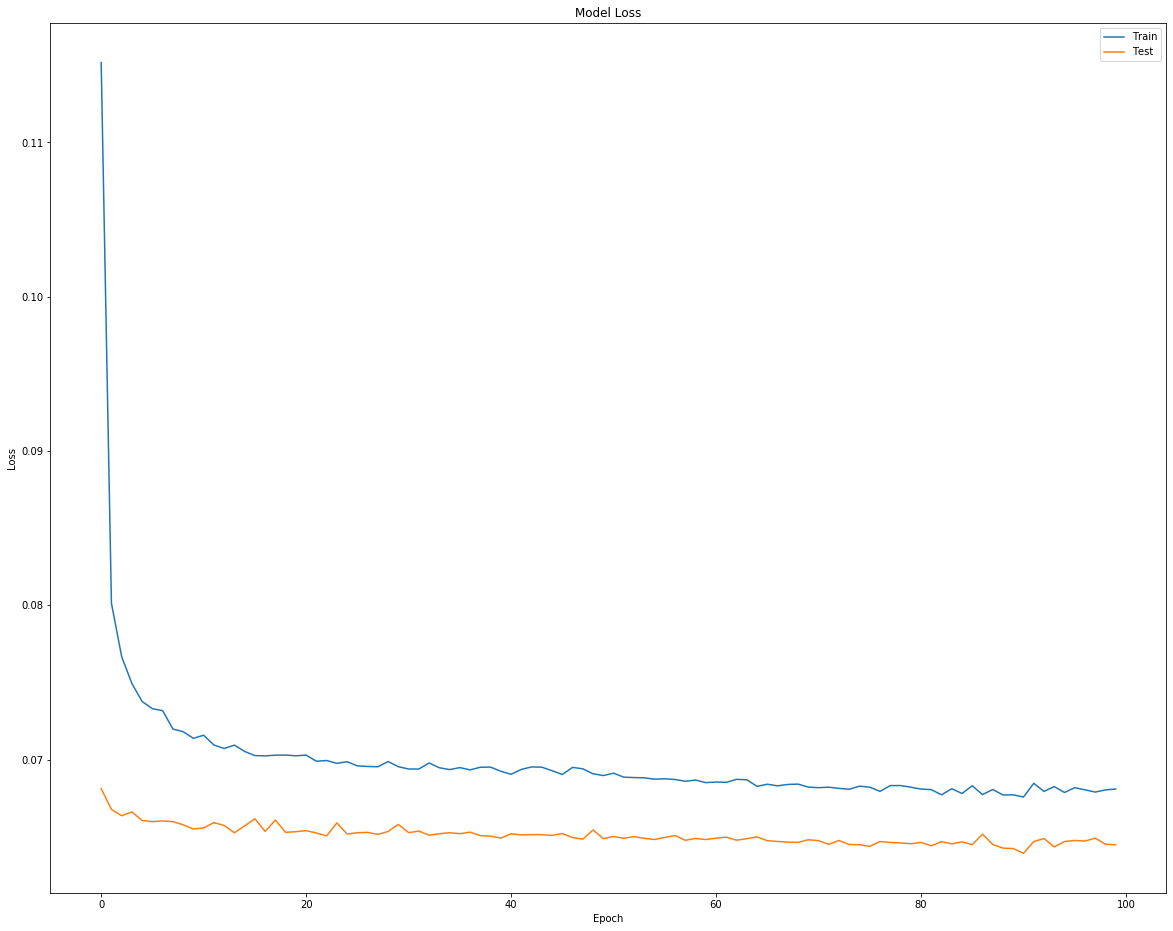

In [28]:
fig, ax = plt.subplots(figsize=(20, 16))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [29]:
pred = model.predict(x_test)

In [30]:
def compute_metrics(pred, y_test):
    y_pred = np.round(pred).astype(int)
    
    correct = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {correct}")
    
    recall = metrics.recall_score(y_test, y_pred, average = 'weighted')    
    print(f"Recall: {recall}")
       
    precision = metrics.precision_score(y_test, y_pred, average = 'weighted')
    print(f"Precision: {precision}")
    
    f1score = metrics.f1_score(y_test, y_pred, average = 'weighted')
    print(f"F1Score: {f1score}")

In [31]:
compute_metrics(pred, y_test)

Accuracy: 0.9843463809940762
Recall: 0.9843463809940762
Precision: 0.9897300882558933
F1Score: 0.9860077883609134


-------------------------------------

**Result Plots**

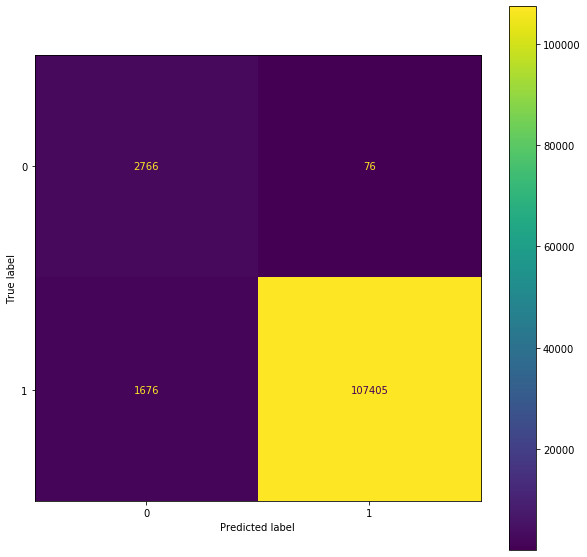

In [32]:
# Compute confusion matrix
y_pred = np.round(pred).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax)

In [33]:
# Usage of ExtraTreesClassifier for feature selection
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)
extra_tree_forest.fit(x, y)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

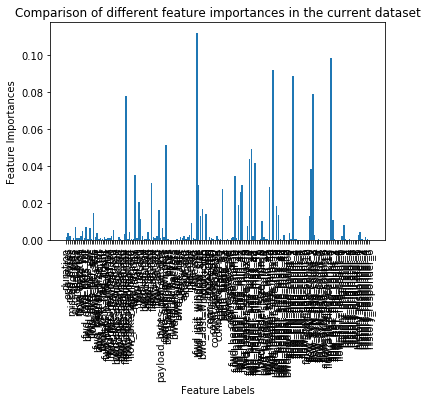

In [34]:
# Plor for the ExtraTreesClassifier output
plot.bar(x_columns, feature_importance_normalized)
plot.xlabel('Feature Labels')
plot.ylabel('Feature Importances')
plot.title('Comparison of different feature importances in the current dataset')
plot.xticks(rotation = 90)

# Plot size
plot.rcParams["figure.figsize"] = (70, 40)

plot.show()

## 